# Reading the Files from the local machine


In [ ]:
# from google.colab import files
# uploaded = files.upload()

# Importing the necessary modules

In [ ]:
import librosa
import librosa.display
import os
import matplotlib.pyplot as plt
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPool2D, BatchNormalization , Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore")

# Mounting the Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Exploration/ Data Visualization

In [ ]:
def plot_waveform(path, num_rows=2, num_cols=5):
  # List all subdirectories (folders) in the specified directory
  folders = next(os.walk(path))[1]

  # Define the number of rows and columns for subplots
  num_rows = 2
  num_cols = 5

  # Create a figure with subplots
  fig, axs = plt.subplots(num_rows, num_cols,figsize=(20,6), squeeze=False)

  # Iterate over the folders and plot the waveform for each audio file
  for i, folder in enumerate(folders):
      if i >= num_rows * num_cols:
          break  # Limit the number of genres to plot based on the number of subplots
      folder_path = os.path.join(path, folder)
      for j, file in enumerate(os.listdir(folder_path)):
          if file.endswith('.wav'):
              if j >= num_cols:
                  break  # Limit the number of audio files to plot based on the number of columns
              file_path = os.path.join(folder_path, file)
              audio, sr = librosa.load(file_path)
              row = i // num_cols
              col = i % num_cols
              plot=librosa.display.waveshow(audio, sr=sr, ax=axs[row, col])
              axs[row, col].set_title(f'{folder}')


  plt.tight_layout()
  fig.suptitle("Waveforms")
  fig.subplots_adjust(top=0.90)
  plt.savefig('waveforms_for_audio_files.png', dpi=300)
  plt.show()


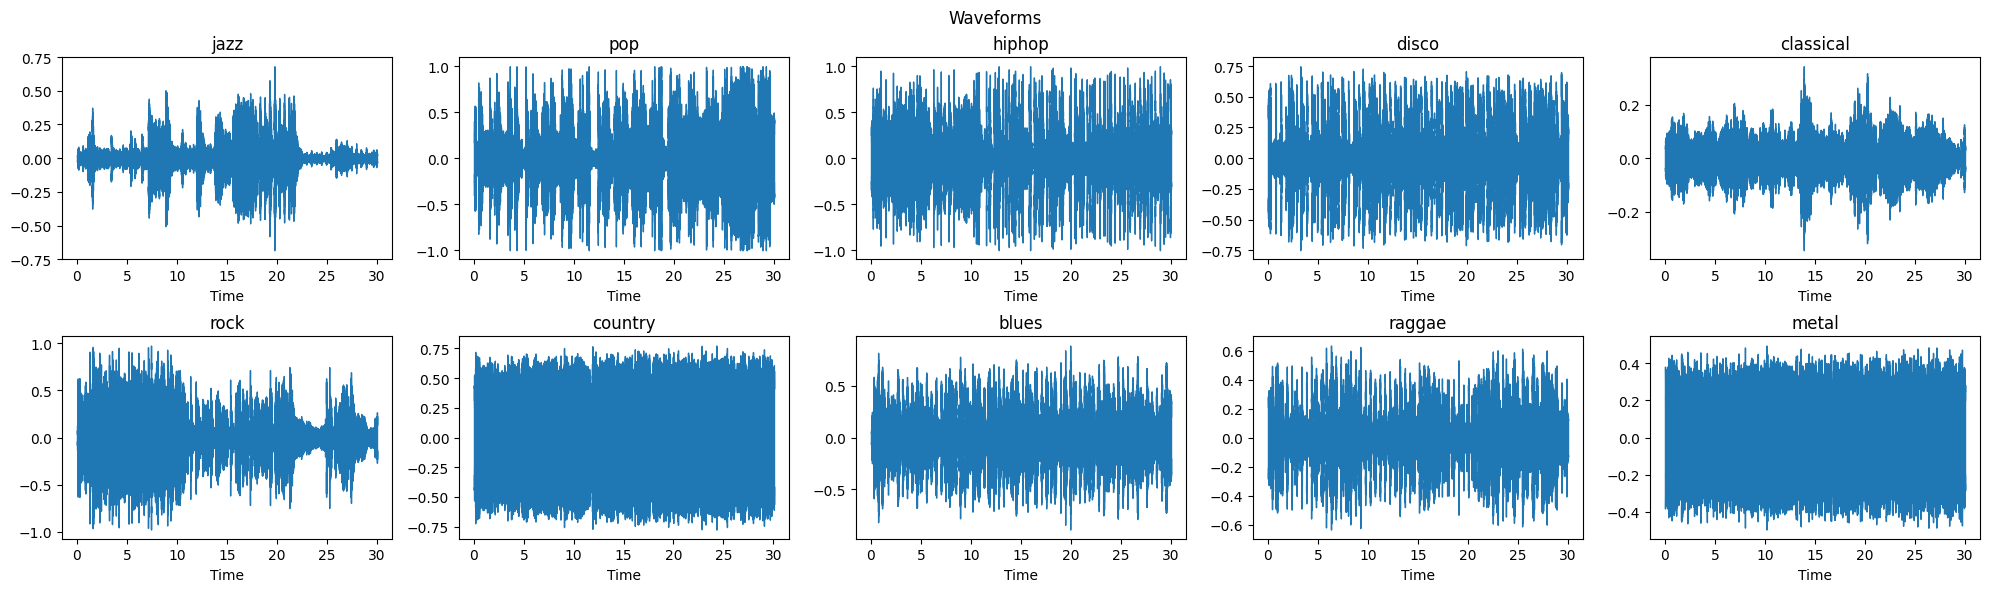

In [ ]:
num_rows = 2
num_cols = 5
directory_path = '/content/drive/MyDrive/music_genre/'
plot_waveform(directory_path, num_rows=2, num_cols=5)

In [ ]:
def plot_mel_spectrogram(path, num_rows=2, num_cols=5):
  #  List all subdirectories (folders) in the specified directory
  folders = next(os.walk(path))[1]

  # Define the number of rows and columns for subplots
  num_rows = 2
  num_cols = 5

  # Create a figure with subplots
  fig, axs = plt.subplots(num_rows, num_cols, figsize=(16, 8), squeeze=False)

  # Iterate over the folders and plot the spectrogram for each audio file
  for i, folder in enumerate(folders):
      if i >= num_rows * num_cols:
          break  # Limit the number of genres to plot based on the number of subplots
      folder_path = os.path.join(path, folder)
      for j, file in enumerate(os.listdir(folder_path)):
          if file.endswith('.wav'):
              if j >= num_cols:
                  break  # Limit the number of audio files to plot based on the number of columns
              file_path = os.path.join(folder_path, file)
              audio, sr = librosa.load(file_path)
              spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr)
              log_spectrogram = librosa.amplitude_to_db(spectrogram, ref=np.max)
              row = i // num_cols
              col = i % num_cols
              axs[row, col].imshow(log_spectrogram, aspect='auto', origin='lower', cmap='hot')
              axs[row, col].set_title(f'{folder}')
              axs[row, col].set_xlabel('Time')
              axs[row, col].set_ylabel('Mel Frequency')

  plt.tight_layout()
  fig.subplots_adjust(top=0.90)
  fig.suptitle("Mel Spectrogram")
  plt.savefig('spectrograms_for_audio_files.png', dpi=300)
  plt.show()



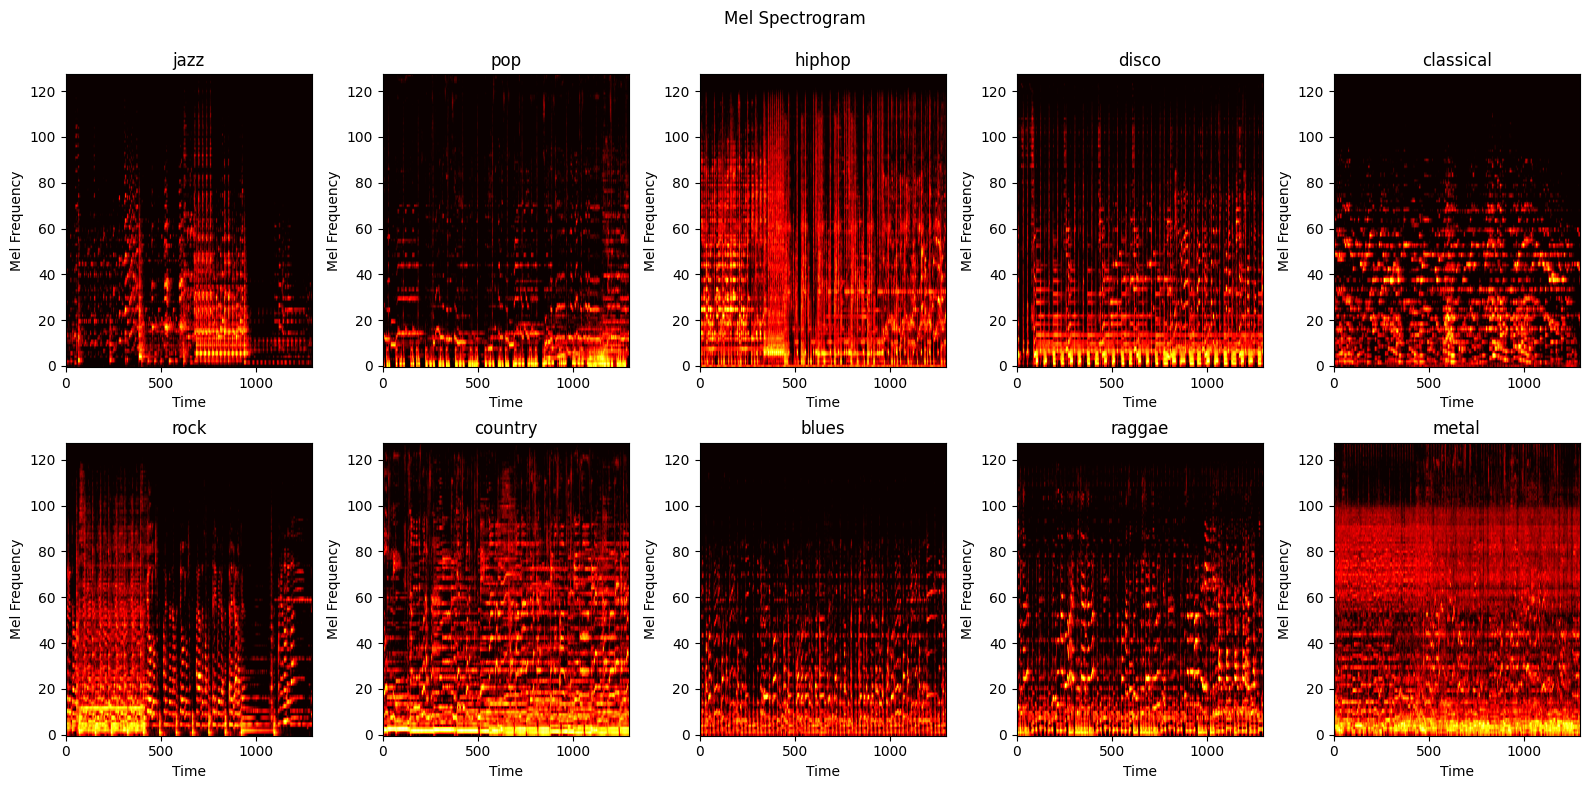

In [ ]:
plot_mel_spectrogram(directory_path, num_rows=2, num_cols=5)

# Reading in the Data

In [ ]:
def load_data(file_path):
    try:
        with open(file_path) as file:
            data = json.load(file)
            X= data['mel_spectrograms']
            y = data["targets"]
        return X, y
    except json.JSONDecodeError as e:
        print(f"JSON decoding error: {e.msg} at line {e.lineno}, column {e.colno}")

In [ ]:
file_path = "/content/drive/MyDrive/Data Science/audio_features.json"
try:
    X, y = load_data(file_path)
except FileNotFoundError:
    print("File not found!")

In [ ]:
print(type(X))

<class 'list'>


# preparing the data to passed to the model

In [ ]:
def prepare_data(X,y,test_size=0.1, validation_size=0.1):

    # dividing the data into test, train sets
    X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=test_size)

    # dividing the Training set into Training and validation dataset
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size= validation_size)


    #Creating a new axis for the numpy array to make it a 4 d array
    X_train=X_train[..., np.newaxis]
    X_validation=X_validation[..., np.newaxis]
    X_test=X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation , y_test

In [ ]:
X_train, X_validation, X_test, y_train, y_validation , y_test = prepare_data(np.array(X), np.array(y))

# Creating the CNN model

In [ ]:
def cnn_model(input_shape):
    #Creating the model
    neural_network=Sequential()


    # creating the 1st Convolutional Layer
    neural_network.add(Conv2D(32, (2,2), activation='relu', input_shape=input_shape))
    neural_network.add(MaxPool2D((2,2), strides= (1,1), padding ='same'))
    neural_network.add(BatchNormalization())

    #Creating the 2nd Convolutional Layer
    neural_network.add(Conv2D(64, (2,2), activation='relu'))
    neural_network.add(MaxPool2D((2,2), strides= (1,1), padding ='same'))
    neural_network.add(BatchNormalization())

    #creating the 3rd Convolutional layer
    neural_network.add(Conv2D(32, (2,2), activation='relu'))
    neural_network.add(MaxPool2D((2,2), strides= (1,1), padding ='same'))
    neural_network.add(BatchNormalization())

    #Flattening the Output and feeding into a dense layer
    neural_network.add(Flatten())
    neural_network.add(Dense(64, activation='relu'))
    neural_network.add(Dropout(0.3))

    #Output layer
    neural_network.add(Dense(10, activation= 'softmax'))

    return neural_network



# Initiating the CNN model

In [ ]:
# The input shape for the neural network
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])

# Define the metrics
precision = Precision()
recall = Recall()

#initializing the model
model= cnn_model(input_shape )

# Compile the model with Adam optimizer
optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy',precision, recall])

# Summary of the Model

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 127, 4, 32)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 4, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 127, 4, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 126, 3, 64)        8256      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 126, 3, 64)       0         
 2D)                                                             
                                                        

# Training the Model

In [ ]:
hist = model.fit(X_train, y_train, epochs=50, validation_data=(X_validation,y_validation), batch_size=16)

Epoch 1/50
1013/1013 [==============================] - 20s 7ms/step - loss: 2.0398 - accuracy: 0.2759 - precision: 0.6374 - recall: 0.0949 - val_loss: 2.2353 - val_accuracy: 0.2722 - val_precision: 0.5172 - val_recall: 0.0833
Epoch 2/50
1013/1013 [==============================] - 8s 8ms/step - loss: 1.6529 - accuracy: 0.3968 - precision: 0.7185 - recall: 0.2055 - val_loss: 2.0211 - val_accuracy: 0.3544 - val_precision: 0.4152 - val_recall: 0.2217
Epoch 3/50
1013/1013 [==============================] - 7s 7ms/step - loss: 1.3634 - accuracy: 0.5027 - precision: 0.7585 - recall: 0.3362 - val_loss: 3.3184 - val_accuracy: 0.2767 - val_precision: 0.3357 - val_recall: 0.2317
Epoch 4/50
1013/1013 [==============================] - 9s 9ms/step - loss: 1.1317 - accuracy: 0.5859 - precision: 0.7987 - recall: 0.4484 - val_loss: 3.2666 - val_accuracy: 0.2550 - val_precision: 0.2910 - val_recall: 0.2239
Epoch 5/50
1013/1013 [==============================] - 7s 7ms/step - loss: 0.9387 - accuracy: 

# Evaluating the model on the test data set

In [ ]:
evaluation_results = model.evaluate(X_test, y_test)
accuracy = evaluation_results[1]  # Assuming accuracy is the second metric in the list
print('Test Accuracy:', accuracy)



63/63 [==============================] - 0s 4ms/step - loss: 0.4956 - accuracy: 0.8240 - precision: 0.8786 - recall: 0.7850
Test Accuracy: 0.8240000009536743


In [ ]:
rows =[]
cols =[]

for i in range(2):
  for j in range(2):
    rows.append(i)
    cols.append(j)

# Plotting the Performance of the CNN Neural Network

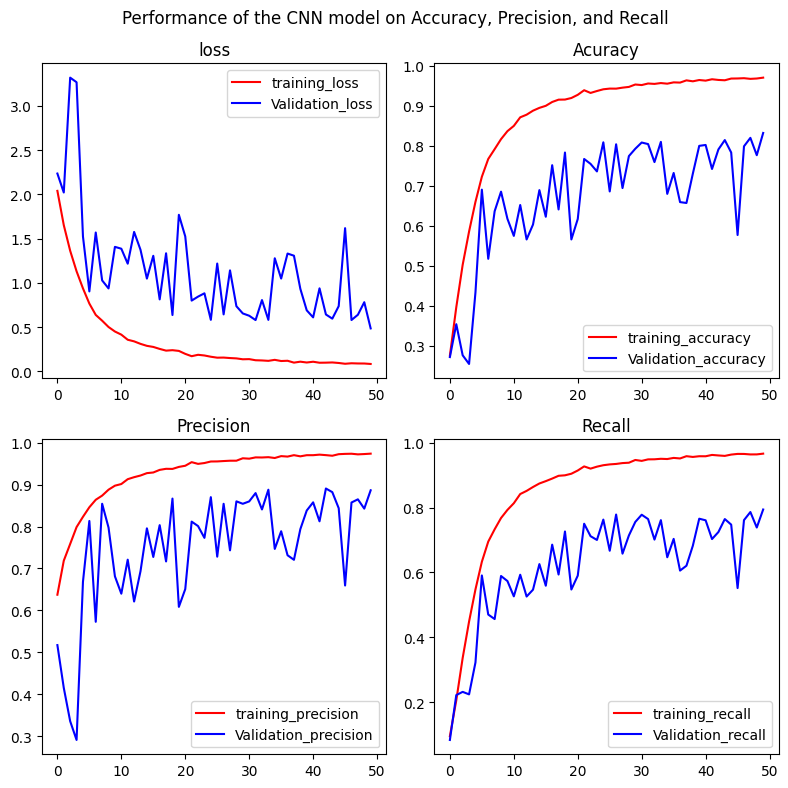

In [ ]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize = (8, 8))

ax1.set_title('loss')
ax1.plot(hist.history['loss'], 'r')
ax1.plot(hist.history['val_loss'], 'b')
ax1.legend(['training_loss', 'Validation_loss'])


ax2.set_title('Acuracy')
ax2.plot(hist.history['accuracy'], 'r')
ax2.plot(hist.history['val_accuracy'], 'b')
ax2.legend(['training_accuracy', 'Validation_accuracy'])

ax3.set_title('Precision')
ax3.plot(hist.history['precision'], 'r')
ax3.plot(hist.history['val_precision'], 'b')
ax3.legend(['training_precision', 'Validation_precision'])

ax4.set_title('Recall')
ax4.plot(hist.history['recall'], 'r')
ax4.plot(hist.history['val_recall'], 'b')
ax4.legend(['training_recall', 'Validation_recall'])

fig.suptitle("Performance of the CNN model on Accuracy, Precision, and Recall")
fig.subplots_adjust (top=0.90)
plt.tight_layout()
plt.savefig("Performance of the model.png", dpi=300)
plt.show()

# plotting the Recall of the model

In [ ]:
plt.title('Recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.legend(['training_recall', 'Validation_recall'])
plt.show()